In [21]:
import numpy as np
import copy
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
%gui qt5
import time

In [22]:
#set up plottig GUI
app = QtGui.QApplication([])
pg.setConfigOption('background','w')  

In [25]:
win = pg.GraphicsWindow(title="Occupancy Detection GUI")
plot1 = win.addPlot()
plot1.setXRange(-6,6)
plot1.setYRange(0,6)
plot1.setLabel('left',text = 'Y position (m)')
plot1.setLabel('bottom', text= 'X position (m)')
s1 = plot1.plot([],[],pen=None,symbol='o')

In [26]:
#Redundant
#rawxycentroidData = (loadmat('C:\\Users\\Abin\\Desktop\\Part4\\Research\\Development\\Kalman\\2peoplecentroidData.mat'))['data'][0]

### Read CSV

In [27]:
def readMeasurements():

    with open('3PeopleCentroidData.csv', newline='') as csvfile:
        data = list(csv.reader(csvfile))

    centroidFramesCartesianMeasurement = list()
    headerFound = False
    for rowIndex in range(0, len(data)):
        row = data[rowIndex]
        if row[0] == 'X' and row[1] == 'Y' and row[2] == 'CentroidNumber':
            if headerFound:
                centroidFramesCartesianMeasurement.append(frame)
                frame = np.array([])
            else:
                headerFound = True
                frame = np.array([])
        elif headerFound:
            if (not((row[0]) and (row[1]))):
                centroidFramesCartesianMeasurement.append(frame)
                headerFound = False
            else:
                X = float(row[0])
                Y = float(row[1])
#                CentroidNumber = (row[2])
                if(np.size(frame) ==0):
                    frame = np.array([[X],[Y]]) #transposed structure
                else:
                    frameTemp= np.array([[X],[Y]])
                    frame = np.hstack((frame,frameTemp))

    for i in range(0,len(centroidFramesCartesianMeasurement)):
        if(np.size(centroidFramesCartesianMeasurement[i]) == 0):
            centroidFramesCartesianMeasurement[i] = np.reshape(centroidFramesCartesianMeasurement[i],(0,0)) #Force dimensions for empty arrays

    return(centroidFramesCartesianMeasurement)

### Helper Functions

In [28]:
def predict(x, P, A, Q): #predict function
    xpred = np.matmul(A,x)
    Ppred = np.matmul(A,P)
    Ppred = np.matmul(Ppred,np.transpose(A)) + Q
    return(xpred, Ppred)

In [29]:
def innovation(xpred, Ppred, z, H, R): #innovation function
    nu = z - np.matmul(H,xpred)
    S = np.matmul(H,Ppred)
    S = R + np.matmul(S, np.transpose(H))
    return(nu, S)


In [30]:
def innovation_update(xpred, Ppred, nu, S, H):
    K = np.matmul(Ppred, np.transpose(H))
    K = np.matmul(K,np.linalg.inv(S)) #check inverse function
    xnew = xpred + np.matmul(K,nu)
    Pnew = np.matmul(K,S)
    Pnew = Ppred - np.matmul(Pnew,np.transpose(K)) 
    return(xnew, Pnew)

In [31]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

### Association

In [32]:
def data_associate(centroidPred, rthetacentroid):
    rthetacentroidCurrent = rthetacentroid
    centpredCol = np.size(centroidPred,1)
    rthetaCol = np.size(rthetacentroid,1)

    for i in list(range(0,centpredCol)):
        r1 = centroidPred[0][i]
        r2 = rthetacentroid[0]
        theta1 = centroidPred[2][i]
        theta2 = rthetacentroid[1]
        temp = np.sqrt(np.multiply(r1,r1) + np.multiply(r2,r2) - np.multiply(np.multiply(np.multiply(2,r1),r2),np.cos(theta2-theta1)))
        if(i==0):
            minDist = temp
        else:
            minDist = np.vstack((minDist,temp))

    currentFrame = np.empty((2,max(centpredCol,rthetaCol)))
    currentFrame[:] = np.nan

    minDist = np.reshape(minDist, (centpredCol,rthetaCol))
    minDistOrg = minDist

    for i in list(range(0,min(centpredCol,rthetaCol))):
        if((np.ndim(minDist)) == 1):
            minDist = np.reshape(minDist,(rthetaCol,1))
            minDistOrg = np.reshape(minDistOrg,(rthetaCol,1))
        val = np.min(minDist)
        resultOrg = np.argwhere(minDistOrg == val)
        result = np.argwhere(minDist == val)
        minRowOrg = resultOrg[0][0]
        minColOrg = resultOrg[0][1]
        minRow = result[0][0]
        minCol = result[0][1]
        currentFrame[:,minRowOrg] = rthetacentroid[:,minColOrg]
        minDist = np.delete(minDist,minRow,0)
        minDist = np.delete(minDist,minCol,1)
        rthetacentroidCurrent = np.delete(rthetacentroidCurrent,minCol,1)

    index = 0
    if (rthetacentroidCurrent.size != 0): #check indexing
        for i in list(range(centpredCol,rthetaCol)):
            currentFrame[:,i] = rthetacentroidCurrent[:,index]
            index += 1 

    return(currentFrame)

### Main Code

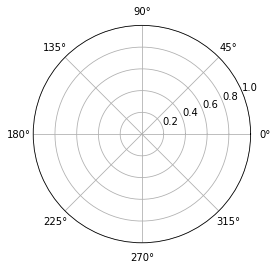

In [33]:
#initialise matrices 
centroidX =np.zeros((4,1))
centroidP = []
delT = 0.0500
A = np.array([[1,delT,0,0], [0,1,0,0], [0,0,1,delT], [0,0,0,1]])
H = np.array([[1,0,0,0],[0,0,1,0]])
P = np.identity(4);
Q = np.multiply(0.9,np.identity(4))
R = np.array([[1],[1]])
centroidP.extend([P])
sensorUpperLimit = 10
sensorLowerLimit = 0

plt.figure()
theta1 = []
radius1 = []
theta2 = []
radius2 = []
theta3 = []
radius3 = []
ax = plt.subplot(111, projection='polar')

rawxycentroidData = readMeasurements()

for currentrawxycentroidData in rawxycentroidData:

    xytransposecentroidData = currentrawxycentroidData
    rthetacentroidData=xytransposecentroidData
    if (xytransposecentroidData.size != 0): 
        [rthetacentroidData[0,:],rthetacentroidData[1,:]] = cart2pol(xytransposecentroidData[0,:],xytransposecentroidData[1,:])
    if((rthetacentroidData.size != 0)):
        currentFrame = data_associate(centroidX, rthetacentroidData)
        addittionalCentroids = (np.size(rthetacentroidData,1)-np.size(centroidX,1))
        if(addittionalCentroids>0):
            truncateCurrentFrame = currentFrame[:,np.size(centroidX,1):np.size(currentFrame,1)]
            zeroTemplate = np.zeros((4,np.size(truncateCurrentFrame,1)),dtype=truncateCurrentFrame.dtype)
            zeroTemplate[[0,2],:] = truncateCurrentFrame[[0,1],:]
            centroidX = np.hstack((centroidX,zeroTemplate))
            for newFrameIndex in list((range(0, addittionalCentroids))):
                centroidP.extend([P])
        for currentFrameIndex in list((range(0,np.size(currentFrame,1)))):
            if(not(np.isnan(currentFrame[0,currentFrameIndex]))):
                [xpred, Ppred] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)
                [nu, S] = innovation(xpred, Ppred, currentFrame[:, currentFrameIndex], H, R)
                [centroidX[:,currentFrameIndex],  centroidP[currentFrameIndex]] = innovation_update(xpred, Ppred, nu, S, H)
            else:
                [centroidX[:,currentFrameIndex], centroidP[currentFrameIndex]] = predict(centroidX[:,currentFrameIndex], centroidP[currentFrameIndex], A, Q)                   
    else:
        for noFrameIndex in list((range(0,np.size(centroidX,1)))):
            [centroidX[:,noFrameIndex], centroidP[noFrameIndex]] = predict(centroidX[:,noFrameIndex], centroidP[noFrameIndex], A, Q)

#     currentY = centroidX[0,:]*np.sin(centroidX[2,:])
#     radiusLimitIndex = np.argwhere(((currentY<sensorUpperLimit)&(currentY>=sensorLowerLimit)))
#     radiusLimitIndexSliced = radiusLimitIndex[:,0]
#     centroidX = centroidX[:,radiusLimitIndexSliced]
        
    if(np.size(centroidX,1) > 1):
        theta2.append(centroidX[2][1])
        radius2.append(centroidX[0][1])
    if(np.size(centroidX,1) > 2):
        theta3.append(centroidX[2][2])
        radius3.append(centroidX[0][2])
    if(np.size(centroidX,1) > 0):
        theta1.append(centroidX[2][0])
        radius1.append(centroidX[0][0])

In [34]:
xPos = []
yPos = []
for i in range(0, len(radius1)):
    xPos = np.append(xPos,radius1[i]*(np.cos(theta1[i])))
    yPos = np.append(yPos, radius1[i]*(np.sin(theta1[i])))
    s1.setData(xPos, yPos)
    QtGui.QApplication.processEvents() 
    time.sleep(0.1)

KeyboardInterrupt: 

In [19]:
H = np.array([[1,0,0,0],[0,0,1,0]])
J = np.array([[1,0,0,0,2,3],[0,0,1,0,4,5]])
print('H is', H)
print('J is', J)
print('H size is ', np.size(H,1), 'J size is', np.size(J,1))
print("Truncate is", J[:,np.size(H,1):np.size(J,1)])
truncate = J[:,np.size(H,1):np.size(J,1)]
print('')
print("added is", np.hstack((H,truncate)))

H is [[1 0 0 0]
 [0 0 1 0]]
J is [[1 0 0 0 2 3]
 [0 0 1 0 4 5]]
H size is  4 J size is 6
Truncate is [[2 3]
 [4 5]]
added is [[1 0 0 0 2 3]
 [0 0 1 0 4 5]]


In [ ]:
H = np.array([[1,0,0,0],[0,0,1,0]])
J = np.array([[1,0,0,0,2,3],[0,0,1,0,4,5]])

centroidX = np.hstack((H,currentFrame[:,np.size(centroidX,1):np.size(currentFrame,1)]))

In [59]:
x = np.array([[1,2,3],[4,5,6]])
print('x is ', x)
m,n = x.shape
out = np.zeros((4,3),dtype=x.dtype)
print('out is', out)
out[[0,2],:] = x[[0,1],:]
print('sliced is', out )

x is  [[1 2 3]
 [4 5 6]]
out is [[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
sliced is [[1 2 3]
 [0 0 0]
 [4 5 6]
 [0 0 0]]


In [ ]:
out = np.zeros((4,np.size(truncate,1)),dtype=x.dtype)
out[0,:] = truncate[0,:]
out[2,:] = truncate[1,:]
np.hstack((centroidX,truncate))
